## NLP project

Changhyun Kim (k21134342)

In [1]:
# For colab user
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
train_data = pd.read_csv('train.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
dev_data = pd.read_csv('dev.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
test_data = pd.read_csv('test.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])

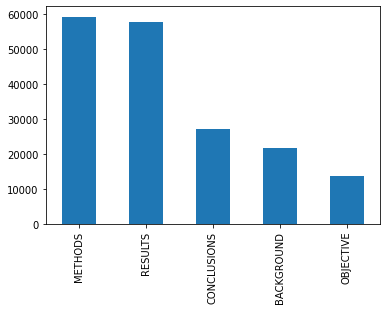

In [4]:
train_data['label'].value_counts().plot(kind='bar')

In [5]:
import nltk
import time
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [6]:
# Cleaning process such that replacing punctuation to space, deleting them, or making them lowercase

def clean_text(text):
    
    punctuation = [i for i in ',./\\;:\'@#~[{]}=+-_)(*&^%$£"!`)]']
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.replace("'s", "")
    text = "".join([" " if t in punctuation else t for t in text]).lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

def split_training_set(X_train, y_train):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
    for first_index, second_index in skf.split(X_train, y_train):
        X_train_f, X_train_s = X_train[first_index], X_train[second_index]
        y_train_f, y_train_s = y_train[first_index], y_train[second_index]
        
    return X_train_f, y_train_f, X_train_s, y_train_s

def evaluate(y_true, y_pred):
    y_true = le.inverse_transform(y_true)
    y_pred = le.inverse_transform(y_pred)    
    print(classification_report(y_true, y_pred))
    result = classification_report(y_true, y_pred, output_dict=True)
    f1 = result['macro avg']['f1-score']
    acc = result['accuracy']
    metrics = ['f1-score macro', 'accuracy']
    return dict(zip(metrics, [f1, acc]))

### Which vectorizer is the best? Tf-idf vs Bag of words
This section aims to find out the best vectorizer that makes the first two machine learning models having better performance with respect to F1-score


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

In [8]:
%%time

train_text_cleaned = train_data['txt'].apply(clean_text)
devel_text_cleaned = dev_data['txt'].apply(clean_text)
test_text_cleaned = test_data['txt'].apply(clean_text)


CPU times: user 46.3 s, sys: 2.57 s, total: 48.8 s
Wall time: 48.8 s


In [9]:
le = LabelEncoder()
y_train = le.fit_transform(train_data['label'])
y_devel = le.transform(dev_data['label'])
y_test = le.transform(test_data['label'])

cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(zip(np.unique(y_train), cw))
cw_dict

{0: 1.657292769365306,
 1: 1.3253828032979977,
 2: 0.6066753154853166,
 3: 2.6019221041982803,
 4: 0.6213310786326851}

In [10]:
bow_vec = CountVectorizer(tokenizer=word_tokenize)
tfidf = TfidfVectorizer(tokenizer=word_tokenize)

random_seed = 42

bow_pipeline = Pipeline([
    ('bow', bow_vec),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])

tfidf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])

print('-------Bag of word result----------')
bow_pipeline.fit(train_text_cleaned, y_train)
y_pred = bow_pipeline.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

print('-------TFIDF result----------')
tfidf_pipeline.fit(train_text_cleaned, y_train)
y_pred = tfidf_pipeline.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

-------Bag of word result----------
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.58      0.55      3449
 CONCLUSIONS       0.65      0.68      0.67      4582
     METHODS       0.86      0.85      0.85      9964
   OBJECTIVE       0.50      0.55      0.53      2376
     RESULTS       0.88      0.82      0.84      9841

    accuracy                           0.76     30212
   macro avg       0.68      0.69      0.69     30212
weighted avg       0.77      0.76      0.76     30212

-------TFIDF result----------
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.60      0.57      3449
 CONCLUSIONS       0.65      0.71      0.68      4582
     METHODS       0.87      0.85      0.86      9964
   OBJECTIVE       0.51      0.61      0.56      2376
     RESULTS       0.89      0.80      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.70      0.72      0.70     30212
weighted av

{'accuracy': 0.7676419965576592, 'f1-score macro': 0.7037006369592815}

From the experiment, we noticed that TFIDF vectorizer is bit more effective to improve LR's performance.

Next, we need to discover the sufficient ngram range for TF-IDF vectorizer to have the best performance. This stage also considers the computational time for each ngram size simultaneously. 

*Result*
bigram and trigram show better performance than unigram. However, for trigram, it takes about 5minutes compared to 11 sec for unigram

ngram_range=(1,2) is reasonable to get feasible running time and better performance

In [11]:
ngram_candidates = [(1,1), (1,2), (1,3)]

for ngram in ngram_candidates:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram)),
        ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
    ])
    tick = time.time()
    pipeline.fit(train_text_cleaned, y_train)
    tock = time.time()
    print('Time elapsed:', tock-tick)
    y_pred = pipeline.predict(devel_text_cleaned)
    evaluate(y_devel, y_pred)

Time elapsed: 21.17337441444397
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.58      0.57      3449
 CONCLUSIONS       0.66      0.71      0.68      4582
     METHODS       0.87      0.85      0.86      9964
   OBJECTIVE       0.51      0.61      0.56      2376
     RESULTS       0.89      0.81      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.69      0.71      0.70     30212
weighted avg       0.78      0.77      0.77     30212

Time elapsed: 121.47965288162231
              precision    recall  f1-score   support

  BACKGROUND       0.60      0.60      0.60      3449
 CONCLUSIONS       0.67      0.75      0.71      4582
     METHODS       0.87      0.87      0.87      9964
   OBJECTIVE       0.56      0.60      0.58      2376
     RESULTS       0.89      0.82      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.72      0.73      0.72     30212
weighted avg

### Model1: Logistic Regression with Tf-idf vectorizer 

The first model which is the baseline model is to use logistic regression. The only given hyperparameter is balancing class weights for handling imbalanced data.

In [12]:
model_results = []

ngram = (1,2)
model_1 = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=word_tokenize, ngram_range=ngram)),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])

model_1.fit(train_text_cleaned, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function word_tokenize at 0x7f20435dbcb0>)),
                ('LR',
                 LogisticRegression(class_weight={0: 1.657292769365306,
                                                  1: 1.3253828032979977,
                                                  2: 0.6066753154853166,
                                                  3: 2.6019221041982803,
                                                  4: 0.6213310786326851},
                                    n_jobs=-1, random_state=42))])

In [13]:
y_pred = model_1.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)


              precision    recall  f1-score   support

  BACKGROUND       0.59      0.60      0.59      3449
 CONCLUSIONS       0.65      0.75      0.70      4582
     METHODS       0.86      0.87      0.87      9964
   OBJECTIVE       0.55      0.64      0.59      2376
     RESULTS       0.90      0.80      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.71      0.73      0.72     30212
weighted avg       0.79      0.78      0.78     30212



{'accuracy': 0.7790282007149477, 'f1-score macro': 0.7193142843567532}

In [14]:
combined_text_data = pd.concat([train_text_cleaned, devel_text_cleaned], axis=0)
len(combined_text_data)
combined_text_label = np.concatenate([y_train, y_devel], axis=0)

tick = time.time()
model_1.fit(combined_text_data, combined_text_label)
tock = time.time()

print("Time elapsed for training: %.3f" % (tock - tick))

y_pred = model_1.predict(test_text_cleaned)
model1_result = evaluate(y_test, y_pred)
model_results.append(model1_result)

Time elapsed for training: 166.212
              precision    recall  f1-score   support

  BACKGROUND       0.60      0.60      0.60      3621
 CONCLUSIONS       0.66      0.76      0.71      4571
     METHODS       0.87      0.87      0.87      9897
   OBJECTIVE       0.55      0.62      0.58      2333
     RESULTS       0.90      0.81      0.85      9713

    accuracy                           0.78     30135
   macro avg       0.72      0.73      0.72     30135
weighted avg       0.79      0.78      0.79     30135



### Model2: Linear SVM with Tf-idf Vectorizer

The next model is Linear SVM with the same technique for imbalanced data. Additional hyperparameter for SVM is cost parameter which is set to 1.

In [15]:
model_2 = Pipeline([
    ("tf-idf", TfidfVectorizer(tokenizer=word_tokenize, ngram_range=ngram)),
    ("LinearSVM", LinearSVC(class_weight=cw_dict, random_state=random_seed, C=1))
])
model_2.fit(train_text_cleaned, y_train)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function word_tokenize at 0x7f20435dbcb0>)),
                ('LinearSVM',
                 LinearSVC(C=1,
                           class_weight={0: 1.657292769365306,
                                         1: 1.3253828032979977,
                                         2: 0.6066753154853166,
                                         3: 2.6019221041982803,
                                         4: 0.6213310786326851},
                           random_state=42))])

In [16]:
y_pred = model_2.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.61      0.58      0.60      3449
 CONCLUSIONS       0.70      0.73      0.71      4582
     METHODS       0.85      0.91      0.88      9964
   OBJECTIVE       0.61      0.57      0.59      2376
     RESULTS       0.89      0.85      0.87      9841

    accuracy                           0.80     30212
   macro avg       0.73      0.73      0.73     30212
weighted avg       0.80      0.80      0.80     30212



{'accuracy': 0.7972328875943334, 'f1-score macro': 0.7298209444989865}

In [17]:
tick = time.time()
model_2.fit(combined_text_data, combined_text_label)
tock = time.time()

print("Time elapsed for training: %.3f" % (tock - tick))

y_pred = model_2.predict(test_text_cleaned)
model2_result = evaluate(y_test, y_pred)
model_results.append(model2_result)

Time elapsed for training: 55.866
              precision    recall  f1-score   support

  BACKGROUND       0.62      0.58      0.60      3621
 CONCLUSIONS       0.70      0.74      0.72      4571
     METHODS       0.85      0.91      0.88      9897
   OBJECTIVE       0.60      0.56      0.58      2333
     RESULTS       0.89      0.84      0.86      9713

    accuracy                           0.79     30135
   macro avg       0.73      0.73      0.73     30135
weighted avg       0.79      0.79      0.79     30135



### Model3: Bidirectional LSTM network

#### Word Embedding layer
Prior to build word embedding layer, the texts were vectorized using `TextVectorization`. The vectors are encoded as 55 word sequence length which covers 95% of the sentences in the training set. The max size of vocabulary of this vectorizer is 68,000 which is the total number of vocabulary in the training set. After vectorizing, embedding dimension is set to 200 as my machine can handle.
#### Bidirectional LSTM
- LSTM units: 64
- Embedding dimension: 200
- Dropout rate: 0.2
- Activation: ReLU
- Dense layer units: 32

#### Training setting
- epochs = 5
- batch_size = 256
- balancing class weights


In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

sentence_len = [len(sent.split()) for sent in train_data['txt'].tolist()]
np.percentile(sentence_len, 95)

55.0

In [19]:
max_tokens = 68000
seq_len = 55

text_vec = TextVectorization(max_tokens=max_tokens, 
                             pad_to_max_tokens=True, 
                             output_sequence_length=seq_len,
                             output_mode='int')
text_vec.adapt(train_text_cleaned)

In [20]:
from tensorflow.keras.utils import to_categorical, set_random_seed
from keras.layers import Embedding, Dropout, Dropout, Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, Bidirectional, LSTM, Input
from sklearn.metrics import f1_score

random_seed = 42
embedding_dim = 200
hidden_dims=32
filter1 = 64
dropout_rate=0.2
input_dim = len(text_vec.get_vocabulary())
set_random_seed(random_seed)
# np.set_random_seed(random_seed)

y_train_vec = to_categorical(y_train, num_classes=5, dtype=int)
y_devel_vec = to_categorical(y_devel, num_classes=5, dtype=int)
y_test_vec = to_categorical(y_test, num_classes=5, dtype=int)

# x_train = pad_sequences(train_text_cleaned, maxlen=seq_len)
# x_test = pad_sequences(devel_text_cleaned, maxlen=seq_len)

In [21]:
def create_model3():
  model_3 = tf.keras.Sequential()

  model_3.add(tf.keras.Input(shape=(1,), dtype=tf.string))
  model_3.add(text_vec)
  model_3.add(Embedding(input_dim=input_dim,
                      output_dim=embedding_dim,
                      mask_zero=True,
                    input_length=seq_len))
  model_3.add(Bidirectional(LSTM(filter1, return_sequences=False)))
  model_3.add(Dropout(dropout_rate))

  model_3.add(Dense(hidden_dims, activation='relu'))
  model_3.add(Dropout(dropout_rate))

  model_3.add(Dense(5, activation='softmax'))

  model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  print('Finished building model.\n')
  print(model_3.summary())
  return model_3

In [22]:
model_3 = create_model3()
model_3.fit(train_text_cleaned, y_train_vec, class_weight=cw_dict, batch_size=256, epochs=5, validation_data=(devel_text_cleaned, y_devel_vec))

Finished building model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 200)           11580400  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (

In [23]:
model_3 = create_model3()
combined_text_data = pd.concat([train_text_cleaned, devel_text_cleaned], axis=0)
combined_labels_vec = np.concatenate([y_train_vec, y_devel_vec], axis=0)
model_3.fit(combined_text_data, combined_labels_vec, class_weight=cw_dict, batch_size=256, epochs=5)

y_pred_vec = model_3.predict(test_text_cleaned)
y_pred = np.argmax(y_pred_vec, axis=1)
model3_result = evaluate(y_test, y_pred)
model_results.append(model3_result)

Finished building model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 55, 200)           11580400  
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)        

### Model4: Different embedding layer with the Bidirectional LSTM network

Model 4 uses GloVe embedding sourced by [Stanford NLP lab](https://nlp.stanford.edu/projects/glove/).
- Used 200 dimension version
- All other settings are identical to the previous model



In [24]:
from numpy import array

# loading pre-trained weights and build embedding layer
embeddings_index = dict()
f = open('glove.6B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [25]:
embedding_matrix = np.zeros((input_dim + 1, embedding_dim))
for i, word in enumerate(text_vec.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = Embedding(input_dim + 1, 
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=seq_len,
                            trainable=False,
                            name='embedding_layer')

In [27]:
def create_model4():
  model_4 = tf.keras.Sequential()

  model_4.add(Input(shape=(1,), dtype=tf.string))
  model_4.add(text_vec)
  model_4.add(embedding_layer)
  model_4.add(Bidirectional(LSTM(filter1, return_sequences=False)))
  model_4.add(Dropout(0.2))
  model_4.add(Dense(hidden_dims, activation='relu'))
  model_4.add(Dropout(0.2))

  model_4.add(Dense(5, activation='softmax'))

  model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  print('Finished building model.\n')
  print(model_4.summary())
  return model_4

In [28]:
model_4 = create_model4()
model_4.fit(train_text_cleaned, y_train_vec, class_weight=cw_dict, batch_size=256, epochs=5, validation_data=(devel_text_cleaned, y_devel_vec))

Finished building model.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 55, 200)          11580600  
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)        

In [29]:
model_4 = create_model4()
model_4.fit(combined_text_data, combined_labels_vec, class_weight=cw_dict, batch_size=256, epochs=5)

y_pred_vec = model_4.predict(test_text_cleaned)
y_pred = np.argmax(y_pred_vec, axis=1)
model4_result = evaluate(y_test, y_pred)
model_results.append(model4_result)

Finished building model.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 55, 200)          11580600  
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_7 (Dropout)        

### Model5: Model from the paper

The last model is built as follows:

- The sequential information of sentences can be extracted from the dataset. Each `pmid` has several sentences and each sentence is written in particular line. Therefore, sentence location and total number of lines in the abstract can be manifested. This model uses this data as additional information.
- This should be effective because abstracts are typically structured writing especially medical paper. Additionally, it is obvious the 'METHOD' is followed by 'RESULT'. Such information would be helpful for the model to classify the sentence.

In [30]:
def cal_lines(data):
  lines = []
  current = 0
  count = 0
  data['total_lines'] = 0
  for i, id in enumerate(data['pmid']):
      if current != id:
          data['total_lines'][i-count:i] = count
          current = id
          count = 1
      else:
          count += 1
      lines.append(count)

  data['total_lines'][i-count+1:] = count
  data['line_number'] = lines
  return data

train_data = cal_lines(train_data)
dev_data = cal_lines(dev_data)
test_data = cal_lines(test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [39]:
train_data.head()

,pmid,label,txt,total_lines,line_number
0,24293578,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...,12,1
1,24293578,METHODS,A total of 125 patients with primary knee OA w...,12,2
2,24293578,METHODS,Outcome measures included pain reduction and i...,12,3
3,24293578,METHODS,Pain was assessed using the visual analog pain...,12,4
4,24293578,METHODS,Secondary outcome measures included the Wester...,12,5


In [31]:
from keras.layers import Concatenate
from tensorflow.keras import Model

def create_model5():
  line_model_input = Input(shape=(2,), dtype=tf.int32, name="line_model_input")
  line_model_dense = Dense(hidden_dims, activation='relu', name="line_model_dense")(line_model_input)
  line_model = Model(inputs=line_model_input, outputs=line_model_dense)

  token_model_input = Input(shape=(1,), dtype=tf.string, name="token_model_input")
  token_vector = text_vec(token_model_input)
  token_embedding = embedding_layer(token_vector)
  token_bilstm = Bidirectional(LSTM(filter1, return_sequences=False, name='bi-lstm'))(token_embedding)
  token_bilstm = Dropout(dropout_rate)(token_bilstm)
  token_dense = Dense(hidden_dims, activation='relu', name='token_dense')(token_bilstm)
  token_dense = Dropout(dropout_rate)(token_dense)
  token_model = Model(inputs=token_model_input, outputs=token_dense)

  concat = Concatenate()([token_model.output, line_model.output])
  dense_last = Dense(hidden_dims, activation='relu', name='last_dense')(concat)
  dense_last = Dropout(0.2)(dense_last)

  output = Dense(5, activation='softmax')(dense_last)

  model_5 = Model(inputs=[
                          line_model.input,
                          token_model.input],
                  outputs=output)


  model_5.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  print(model_5.summary())
  return model_5
model_5 = create_model5()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_model_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_model_input[0][0]']      
 ization)                                                                                         
                                                                                                  
 embedding_layer (Embedding)    (None, 55, 200)      11580600    ['text_vectorization[4][0]']     
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 128)         135680      ['embedding_layer[2][0]']  

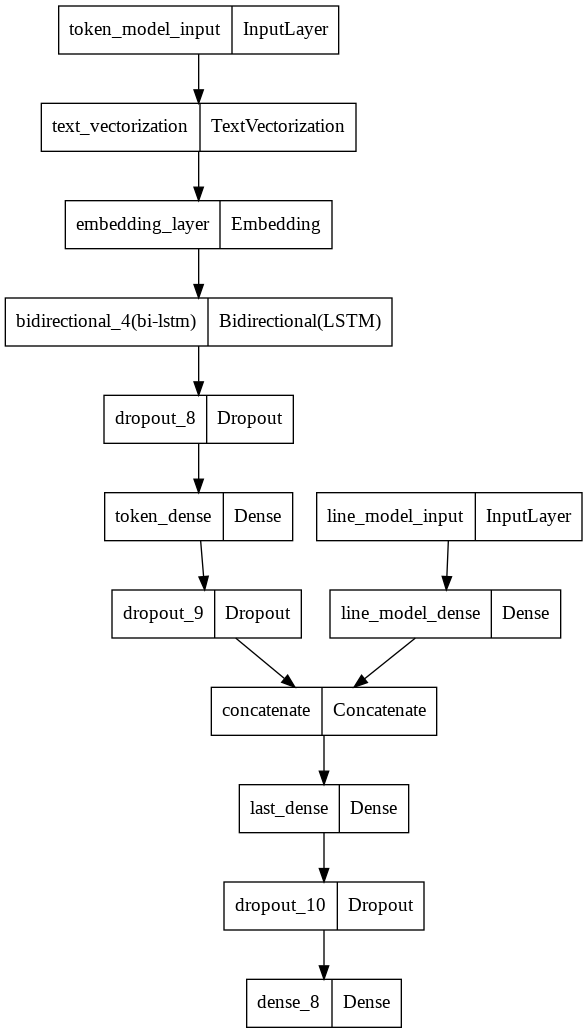

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [33]:
model_5.fit([train_data[['line_number', 'total_lines']], train_text_cleaned], 
            y_train_vec, 
            epochs=5, 
            batch_size=256, 
            validation_data=([dev_data[['line_number', 'total_lines']], devel_text_cleaned], y_devel_vec))

Epoch 1/5
704/704 [==============================] - 16s 18ms/step - loss: 0.5448 - accuracy: 0.7957 - val_loss: 0.3572 - val_accuracy: 0.8659
Epoch 2/5
704/704 [==============================] - 12s 16ms/step - loss: 0.3820 - accuracy: 0.8613 - val_loss: 0.3260 - val_accuracy: 0.8770
Epoch 3/5
704/704 [==============================] - 11s 16ms/step - loss: 0.3540 - accuracy: 0.8721 - val_loss: 0.3181 - val_accuracy: 0.8805
Epoch 4/5
704/704 [==============================] - 12s 17ms/step - loss: 0.3385 - accuracy: 0.8776 - val_loss: 0.3150 - val_accuracy: 0.8795
Epoch 5/5
704/704 [==============================] - 12s 17ms/step - loss: 0.3261 - accuracy: 0.8821 - val_loss: 0.3080 - val_accuracy: 0.8836


In [34]:
model_5 = create_model5()
combined_line_data = pd.concat([train_data[['line_number', 'total_lines']], dev_data[['line_number', 'total_lines']]], axis=0)
model_5.fit([combined_line_data, combined_text_data], combined_labels_vec, class_weight=cw_dict, batch_size=256, epochs=5)

y_pred_vec = model_5.predict([test_data[['line_number', 'total_lines']], test_text_cleaned])
y_pred = np.argmax(y_pred_vec, axis=1)
model5_result = evaluate(y_test, y_pred)
model_results.append(model5_result)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_model_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_model_input[0][0]']      
 ization)                                                                                         
                                                                                                  
 embedding_layer (Embedding)    (None, 55, 200)      11580600    ['text_vectorization[5][0]']     
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 128)         135680      ['embedding_layer[3][0]']  

In [35]:
models = ['model1', 'model2', 'model3', 'model4', 'model5']
model_results = dict(zip(models, model_results))


In [36]:
results = pd.DataFrame(model_results).transpose()
results

,f1-score macro,accuracy
model1,0.722161,0.782346
model2,0.727397,0.793927
model3,0.696540,0.764925
model4,0.734089,0.789580
model5,0.826030,0.870649


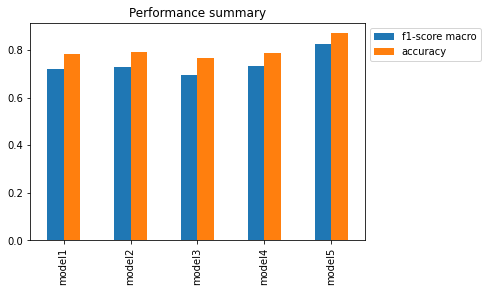

In [37]:
results.plot(kind='bar', title='Performance summary').legend(bbox_to_anchor=(1.0, 1.0));

In [38]:
len(y_test)

30135